In [ ]:
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from zipfile import ZipFile
zf = ZipFile('/content/drive/MyDrive/Explicit_Content Dataset/train.zip', 'r')
zf.extractall('/content/drive/MyDrive/Explicit_Content Dataset/data/')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
import cv2
dir='/content/drive/MyDrive/Explicit_Content Dataset/data/nsfw/'
sav_dir='/content/drive/MyDrive/Explicit_Content Dataset/data/nsfw2/'
fl=os.listdir(dir)
print(len(fl))
for i in range(6999):
    img=os.path.join(dir+fl[i])
    print(img)
    image=cv2.imread(img)
    cv2.imwrite(sav_dir+'image'+"f-{:03d}.jpg".format(i+1),image)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Explicit_Content Dataset/data/nsfw/372403c0-99c4-4534-904b-2083b0922d45.jpg
/content/drive/MyDrive/Explicit_Content Dataset/data/nsfw/37252160-c14d-49bf-91b5-f7788f4c782f.jpg
/content/drive/MyDrive/Explicit_Content Dataset/data/nsfw/37262474-c979-4c11-9375-747ad9ce4041.jpg
/content/drive/MyDrive/Explicit_Content Dataset/data/nsfw/3726626a-a8a3-4d3e-8590-7efc3714c78f.jpg
/content/drive/MyDrive/Explicit_Content Dataset/data/nsfw/37278571-1167-4c09-a087-696d89beb3dc.jpg
/content/drive/MyDrive/Explicit_Content Dataset/data/nsfw/3727921f-7221-43f8-b0ad-624b35d217ff.jpg
/content/drive/MyDrive/Explicit_Content Dataset/data/nsfw/372ad53d-0632-48b9-ac66-e6bf7c94c6fb.jpg
/content/drive/MyDrive/Explicit_Content Dataset/data/nsfw/372bf360-7b60-449e-99ef-55103069eb87.jpg
/content/drive/MyDrive/Explicit_Content Dataset/data/nsfw/372d148d-483c-46a2-8fef-8a630ecdd52b.jpg
/content/drive/MyDrive/Explicit_Content Dataset/data/nsfw/

In [ ]:
img_width, img_height=192,192
input_shape=(img_height,img_width)
train_data_dir='/content/drive/MyDrive/data/train'


In [ ]:
batch_size=28;
#Data augmentation
datagen=ImageDataGenerator(
    rescale=1./244,
    validation_split=0.20,
)
train_generator=datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    subset="training",
    class_mode='binary'   
)
val_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    subset="validation",
    class_mode='binary'

)

In [ ]:
import keras

import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 

from keras.callbacks import LearningRateScheduler

In [ ]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [ ]:
import keras
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [ ]:
input_layer = Input(shape=(192, 192, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(1, activation='sigmoid', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(1, activation='sigmoid', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(1, activation='sigmoid', name='output')(x)

In [ ]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [ ]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 96, 96, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 48, 48, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                                
                                                                                       

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
# opt = Adam(0.01)
opt = Adam(0.00001)
model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
from keras.callbacks import History,ModelCheckpoint, EarlyStopping
# # checkpoint = ModelCheckpoint("/content/drive/MyDrive/Explicit_Content Dataset/", monitor='accuracy', verbose=1, save_best_only=True,
#                              save_weights_only=False)
history=History()
model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=50,callbacks=[history],
    validation_data=validation_generator
    # validation_steps=2
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/50
50/50 [==============================] - 400s 8s/step - loss: 2.1966 - output_loss: 0.7277 - auxilliary_output_1_loss: 0.7309 - auxilliary_output_2_loss: 0.7381 - output_accuracy: 0.5093 - auxilliary_output_1_accuracy: 0.5093 - auxilliary_output_2_accuracy: 0.5093 - val_loss: 2.0785 - val_output_loss: 0.6937 - val_auxilliary_output_1_loss: 0.6917 - val_auxilliary_output_2_loss: 0.6931 - val_output_accuracy: 0.5000 - val_auxilliary_output_1_accuracy: 0.5000 - val_auxilliary_output_2_accuracy: 0.5000
Epoch 2/50
50/50 [==============================] - 143s 3s/step - loss: 2.1598 - output_loss: 0.7249 - auxilliary_output_1_loss: 0.7147 - auxilliary_output_2_loss: 0.7202 - output_accuracy: 0.5257 - auxilliary_output_1_accuracy: 0.5257 - auxilliary_output_2_accuracy: 0.5257 - val_loss: 2.0947 - val_output_loss: 0.7127 - val_auxilliary_output_1_loss: 0.6895 - val_auxilliary_output_2_loss: 0.6925 - val_output_accuracy: 0.5000 - val_auxilliary_output_1_accuracy: 0.5000 - val_auxilli

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss Curves')

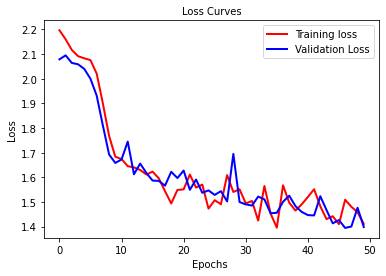

In [ ]:
# Loss Curves
#plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=10)
#plt.grid()
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.title('Loss Curves',fontsize=10)
 

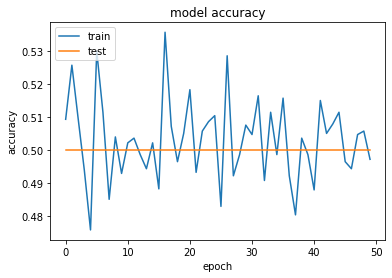

In [ ]:
#summarize History
import matplotlib.pyplot as plt
plt.plot(history.history['output_accuracy'])
plt.plot(history.history['val_output_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [ ]:
test_data_dir='/content/drive/MyDrive/data/test/'
test_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 4000 images belonging to 2 classes.


In [ ]:
result = model.evaluate(test_generator ,batch_size=batch_size)
print("test_loss, test accuracy",result)

126/143 [=========================>....] - ETA: 58s - loss: 1.4082 - output_loss: 0.4616 - auxilliary_output_1_loss: 0.4727 - auxilliary_output_2_loss: 0.4739 - output_accuracy: 0.4331 - auxilliary_output_1_accuracy: 0.4331 - auxilliary_output_2_accuracy: 0.4331 